In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from fastai.tabular.data import RandomSplitter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz
from sklearn.metrics import mean_absolute_error
from fastai.metrics import mae as fast_mae
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
creds = '{"username":"mathieuu","key":"REMOVED"}'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
comp = 'playground-series-s3e16'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/playground-series-s3e16')

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#3) [Path('test.csv'),Path('train.csv'),Path('sample_submission.csv')]

In [6]:
# Feature engineering comes from Kaggle
def transform_dataframe(df):
    # Ratio Features
    df['Total_Weight'] = df['Weight'] + df['Shucked Weight'] + df['Viscera Weight'] + df['Shell Weight']
    df['Viscera_Ratio'] = df['Viscera Weight'] / df['Total_Weight']
    df['Shell_Ratio'] = df['Shell Weight'] / df['Total_Weight']
    df['Shell_to_Body_Ratio'] = df['Shell Weight'] / (df['Total_Weight'] + df['Shell Weight'])
    df['Meat_Yield'] = df['Shucked Weight'] / (df['Total_Weight'] + df['Shell Weight'])
    df['Length_to_Diameter_Ratio'] = df['Length'] / df['Diameter']
    df['Weight_to_VisceraWeight_Ratio'] = df['Total_Weight'] / df['Viscera Weight']
    df['Weight_to_ShellWeight_Ratio'] = df['Total_Weight'] / df['Shell Weight']
    df['Weight_to_ShuckedWeight_Ratio'] = df['Total_Weight'] / df['Shucked Weight']

    # Geometric Features
    df['Surface_Area'] = 2 * (df['Length'] * df['Diameter'] + df['Length'] * df['Height'] + df['Diameter'] * df['Height'])
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    df['Density'] = np.where(df['Volume'] != 0, df['Total_Weight'] / df['Volume'], 0)
    df['Pseudo_BMI'] = np.where(df['Height'] != 0, df['Total_Weight'] / (df['Height'] ** 2), 0)

    # Polynomial Features
    df['Length^2'] = df['Length'] ** 2
    df['Diameter^2'] = df['Diameter'] ** 2

    # Logarithmic Transformations
    df['Log_Weight'] = np.log(df['Total_Weight'] + 1)

    # Binned Features
    df['Length_Bins'] = pd.qcut(df['Length'], 4, labels=False)

    # Derived Weight Features
    df['Weight_wo_Viscera'] = df['Shucked Weight'] - df['Viscera Weight']
    df['Body_Condition_Index'] = np.sqrt(df['Length'] * df['Total_Weight'] * df['Shucked Weight'])

    return df

In [7]:
df_train = transform_dataframe(pd.read_csv(path/'train.csv', low_memory=False))
df_test = transform_dataframe(pd.read_csv(path/'test.csv', low_memory=False))


df_train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Total_Weight,Viscera_Ratio,Shell_Ratio,Shell_to_Body_Ratio,Meat_Yield,Length_to_Diameter_Ratio,Weight_to_VisceraWeight_Ratio,Weight_to_ShellWeight_Ratio,Weight_to_ShuckedWeight_Ratio,Surface_Area,Volume,Density,Pseudo_BMI,Length^2,Diameter^2,Log_Weight,Length_Bins,Weight_wo_Viscera,Body_Condition_Index
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,56.699000,0.117250,0.147250,0.128350,0.195685,1.297872,8.528785,6.791171,4.454343,5.608750,0.671953,84.379398,403.192889,2.325625,1.380625,4.055240,2,6.080968,33.175578
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,20.666785,0.112483,0.164609,0.141343,0.187868,1.333333,8.890244,6.075000,4.570533,2.873750,0.249563,82.812063,273.279808,1.210000,0.680625,3.075780,0,2.197086,10.138784
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,48.335898,0.114956,0.137830,0.121134,0.206186,1.247191,8.698980,7.255319,4.262500,4.962188,0.578848,83.503659,343.721938,1.925156,1.237656,3.898652,2,5.783298,27.577449
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,97.004221,0.113313,0.154600,0.133899,0.181739,1.203540,8.825113,6.468291,4.765635,7.915000,1.200625,80.794771,388.016886,2.890000,1.995156,4.585011,3,9.363103,57.936826
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,45.727744,0.098574,0.130192,0.115195,0.231761,1.234568,10.144654,7.680952,3.817751,4.058438,0.427148,107.053519,401.450698,1.562500,1.025156,3.844338,1,7.470093,26.165615


In [8]:
splits = RandomSplitter()(range_of(df_train))
dep_var = 'Age'
cont,cat = cont_cat_split(df_train, 10, dep_var=dep_var)

In [9]:
(cont,cat)

(['id',
  'Length',
  'Diameter',
  'Height',
  'Weight',
  'Shucked Weight',
  'Viscera Weight',
  'Shell Weight',
  'Total_Weight',
  'Viscera_Ratio',
  'Shell_Ratio',
  'Shell_to_Body_Ratio',
  'Meat_Yield',
  'Length_to_Diameter_Ratio',
  'Weight_to_VisceraWeight_Ratio',
  'Weight_to_ShellWeight_Ratio',
  'Weight_to_ShuckedWeight_Ratio',
  'Surface_Area',
  'Volume',
  'Density',
  'Pseudo_BMI',
  'Length^2',
  'Diameter^2',
  'Log_Weight',
  'Weight_wo_Viscera',
  'Body_Condition_Index'],
 ['Sex', 'Length_Bins'])

# First dark forest attempt

In [11]:
dep_var = 'Age'
cont,cat = cont_cat_split(df_train, 1, dep_var=dep_var)
procs = [Categorify, FillMissing, Normalize]

to = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)

In [12]:
def mae(m, xs, y): return mean_absolute_error(m.predict(xs), y)

In [13]:
xs_train = to.train.xs.drop(columns=['id'])
y_train = to.train.y

xs_val = to.valid.xs.drop(columns=['id'])
y_val = to.valid.y

In [14]:
def rf(xs, y, n_estimators=200, max_samples=74000,
       max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [15]:
rfm = rf(xs_train, y_train, n_estimators=200, max_samples=0.4, max_features=0.7, min_samples_leaf=4)
print(mae(rfm, xs_train, y_train), mae(rfm, xs_val, y_val))

0.8442632636181023 1.450236326806212


# Neural network

In [ ]:
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(df_train, procs, cat, cont, y_names='Age', splits=splits)

SuggestedLRs(valley=0.03981071710586548)

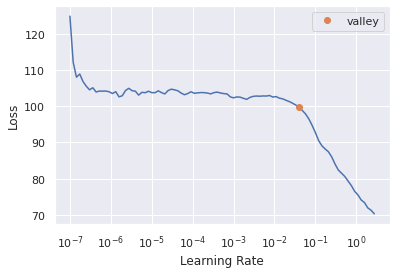

In [25]:
dls = to.dataloaders(64)

learn = tabular_learner(dls, layers=[50,20], metrics=fast_mae)
learn.lr_find()

In [26]:
learn.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,mae,time
0,5.137862,4.606840,1.470999,00:11
1,4.883460,4.756532,1.542802,00:13
2,5.011004,4.636439,1.513071,00:14
3,4.472093,50.040577,1.461536,00:11
4,4.972842,16.451332,1.485612,00:10
5,4.394818,11.741852,1.471224,00:13
6,4.515590,124212.765625,7.996978,00:14
7,4.447653,205953.187500,8.439095,00:13
8,4.534654,3881.554443,2.291540,00:13
9,4.362034,7904.922852,2.223831,00:14


# Submit

In [22]:
test_dl = learn.dls.test_dl(df_test)
preds, _ = learn.get_preds(dl=test_dl)

In [19]:
df_submit = df_test.copy()

def subm(preds, suff):
    df_submit['Age'] = preds
    sub_df = df_submit[['id','Age']]
    sub_df.to_csv(f'sub-crab-{suff}.csv', index=False)

In [20]:
subm(preds, 'initial-neural-network')